In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn rioxarray pytorch-lightning

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import datetime

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



Prepare data

In [3]:
ds = xr.open_dataset("mort_datasets/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

def preprocess_gfw(ds):
    year = os.path.basename(ds.encoding["source"])
    year = int(year.replace(".tif", ""))
    return ds.squeeze(drop=True)\
        .drop_vars("spatial_ref")\
        .rename(band_data="gfw_loss")\
        .assign_coords(time=year)

gfw_mort = xr.open_mfdataset(
    "data_working/gfw_damage/*.tif",
    preprocess=preprocess_gfw,
    concat_dim="time",
    combine="nested"
).compute()

ds = xr.combine_by_coords([ds, gfw_mort]).sel(time=slice(2001, 2023))

In [4]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

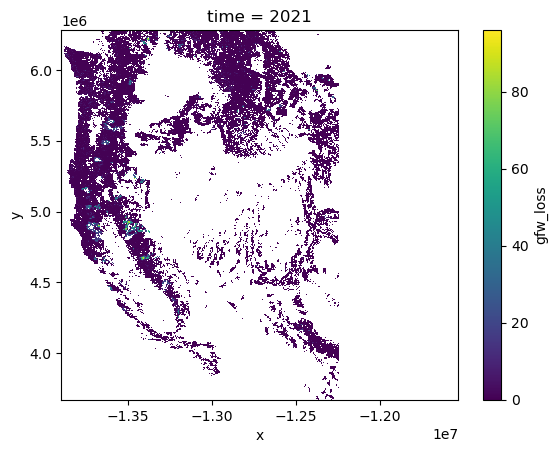

In [5]:
# Mask out GFW pixels that aren't over forest
# FAO definition of forest is 10% cover
ds["gfw_loss"] = ds["gfw_loss"].where(ds["treecover"] >= 10)
ds["gfw_loss"].isel(time=-3).plot()

In [6]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

In [7]:
# Combine GFW and ADS
# 1 = mortality observed, 0 = surveyed but no mort, NoData = unsurveyed
ads_mask = ds["mortality"] > 0 
ds["gfw_masked"] = ds["gfw_loss"] * ads_mask

In [8]:
ds_stack = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)

bands_as_str = [b[0] for b in ds_stack.band.values]

# This is necessary to allow indexing band with str instead of tuples
ds_stack = ds_stack.drop_vars(["band", "variable"])\
    .assign_coords(band=bands_as_str)

ds_stack

<xarray.DataArray 'abies' (time: 23, band: 20, y: 652, x: 590)> Size: 708MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]],
      shape=(23, 20, 652, 590), dtype=float32)
Coordinates:
  * time     (time) int64 184B 2001 2002 2003 2004 2005 ... 2020 2021 2022 2023
  * x        (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * band     (band) <U11 880B 'abies' 'picea' ... 'forest_ba' 'gfw_masked'

Split data into train/valid/test segments.

In [9]:
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

ds_train = ds_stack.sel(time=train_years)
ds_valid = ds_stack.sel(time=valid_years)
ds_test  = ds_stack.sel(time=test_years)

Training years: [2017 2018 2019 2020 2021 2022 2023]
Validation years: [2001 2002 2003 2004 2005 2006 2007 2008]
Testing years: [2009 2010 2011 2012 2013 2014 2015 2016]


Set up windowing parameters.

In [10]:
window_x_size = 5
window_y_size = 5
window_t_size = 5
window = dict(x=[window_x_size, False], y=[window_y_size, False], time=[window_t_size, False])
prop_valid = 0.8

Data pipeline. Given a target variable and bands to use, turn the above datasets into torch dataloaders.

In [11]:
from torch.utils.data import DataLoader

def collator(patches, dtype=torch.float32):
    # Patch dimensions are (time, band, x, y)
    # Target will always be the first band because of selection order.
    X = torch.stack([
        # Exclude last time step
        torch.tensor(
            np.squeeze(patch.values[:-1, ...]),
            dtype=dtype
        )
        for patch in patches
    ])

    # Replace nan cells with the channel mean from this batch
    ch_mean = torch.nanmean(X, dim=0)
    X = torch.nan_to_num(X)
    X += ch_mean * torch.isnan(X)

    # Last time step and target band
    # Normalize to 0-1
    y = torch.stack([
        torch.tensor(patch.values[-1, 0, :, :], dtype=dtype)
        for patch in patches
    ]).squeeze(dim=2)/100

    return X, y

def dataset_to_dataloader(ds, batch_size, target_var, input_bands, **kwargs):
    mask = ds.sel(band=target_var, drop=True)
    ds_subset = ds.sel(band=[target_var]+input_bands)
    ds_window = util.datasets.WindowXarrayDataset(
        ds_subset, window,
        mask=mask, na_thresh=prop_valid
    )

    return DataLoader(
        ds_window, 
        batch_size, 
        collate_fn=collator,
        generator=torch.Generator(device=device),
        **kwargs
    )

In [12]:
# Test that there aren't any NaNs in X and y is at least 80% non-NA
test_loader = dataset_to_dataloader(
    ds_train,
    128,
    "mortality",
    ["prcp", "vp", "elev", "forest_ba"],
    shuffle=True,
    drop_last=True
)

X, y = next(iter(test_loader))

assert((~torch.isnan(X)).all())
assert((~torch.isnan(y)).to(torch.float32).mean() >= prop_valid)

Define naive models. Two forms:
 - last observation: prediction at $t$ is equal to observation at $t-1$
 - cumulative average: prediction at $t$ is equal to mean of observations from $0$ to $t-1$

In [13]:
from sklearn.metrics import r2_score, root_mean_squared_error
from IPython.display import display, JSON, clear_output

def normalized_root_mean_squared_error(y, y_true):
    return root_mean_squared_error(y, y_true) / np.mean(y_true)

def eval_nd_metric_nanmask(y, y_true, m):
    y = y.flatten()
    y_true = y_true.flatten()
    mask = ~np.isnan(y) & ~np.isnan(y_true)
    return m(y[mask], y_true[mask])

def eval_naive_models(ds, target, metrics=[r2_score, root_mean_squared_error]):
    target_arr = ds.sel(band=target)

    target_true = target_arr.values[1:, ...]
    target_last_obs = target_arr.values[:-1, ...]
    target_cumavg = target_arr.cumulative("time").mean().values[:-1, ...]

    return {
        "last_obs": {m.__name__:eval_nd_metric_nanmask(target_last_obs, target_true, m) for m in metrics},
        "cumavg": {m.__name__:eval_nd_metric_nanmask(target_cumavg, target_true, m) for m in metrics}
    }

JSON(eval_naive_models(ds_train, "mort_ewma"), expanded=True)

<IPython.core.display.JSON object>

Define model structure.

In [14]:
from util.convlstm import ConvLSTM, DamageConvLSTM
from collections import OrderedDict
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics

class Model(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.dclstm = DamageConvLSTM(*args, **kwargs)
        self.sigmoid = torch.nn.Sigmoid()

        self.train_nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError()
        self.train_r2    = torchmetrics.regression.PearsonCorrCoef()

        self.valid_nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError()
        self.valid_r2    = torchmetrics.regression.PearsonCorrCoef()

    def forward(self, X):
        X = self.dclstm(X)
        X = self.sigmoid(X)
        X = torch.squeeze(X)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=3, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def _get_loss(self, y, y_hat):
        loss = F.mse_loss(y, y_hat)
        return loss

    def _nan_mask(self, y):
        return ~torch.isnan(y.view(-1))
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y, y_hat)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        self.train_nrmse(y, y_hat)
        self.log("train_nrmse", self.train_nrmse, on_epoch=True, on_step=False)

        self.train_r2(y, y_hat)
        self.log("train_r2", self.train_r2, on_epoch=True, on_step=False)
            
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y, y_hat)
        self.log("valid_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        self.valid_nrmse(y, y_hat)
        self.log("valid_nrmse", self.valid_nrmse, on_epoch=True, on_step=False)

        self.valid_r2(y, y_hat)
        self.log("valid_r2", self.valid_r2, on_epoch=True, on_step=False)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y, y_hat)
        self.log("test_loss", loss, prog_bar=True, on_epoch=True, on_step=False)


input_dim = 5
hidden_dim = 16
num_layers = 3
kernel_size = (3, 3)
dropout = 0.3

m = Model(input_dim, hidden_dim, kernel_size, num_layers, dropout=dropout, batch_first=True)

print("N params:", util.training.count_trainable_parameters(m))

N params: 49307


Function to run an experiment.

In [15]:
def flatten_dict(d):
    return pd.json_normalize(d, sep="_").to_dict(orient="records")[0]

def run_experiment(target_var, input_bands, batch_size, loader_args, model_args, trainer_args):
    # Build dataloaders
    train_dl = dataset_to_dataloader(ds_train, batch_size, target_var, input_bands, shuffle=True,  **loader_args)
    valid_dl = dataset_to_dataloader(ds_valid, batch_size, target_var, input_bands, shuffle=False, **loader_args)
    test_dl  = dataset_to_dataloader(ds_test , batch_size, target_var, input_bands, shuffle=False, **loader_args)

    # Instantiate model
    m = Model(**model_args)

    # Check shapes
    X, y = next(iter(train_dl))
    out = m(X)
    assert (y.shape == out.shape)

    # Get naive results 
    naive_train = eval_naive_models(ds_train, target_var)
    naive_valid = eval_naive_models(ds_valid, target_var)
    naive_test  = eval_naive_models(ds_test , target_var)

    # Log naive results and dataset sizes in the trainer
    trainer = pl.Trainer(
        **trainer_args
    )
    trainer.logger.log_metrics(flatten_dict({"train": naive_train}))
    trainer.logger.log_metrics(flatten_dict({"valid": naive_valid}))
    trainer.logger.log_metrics(flatten_dict({"test" : naive_test}))
    trainer.logger.log_metrics({"n_train":len(train_dl)*batch_size})
    trainer.logger.log_metrics({"n_valid":len(valid_dl)*batch_size})
    trainer.logger.log_metrics({"n_test" :len(test_dl )*batch_size})

    trainer.fit(m, train_dl, valid_dl)

    

In [16]:
batch_size = 128
loader_args = dict(drop_last=True)

model_args = dict(
    hidden_dim=16,
    num_layers=3,
    kernel_size=(3, 3),
    dropout=0.3,
    batch_first=True
)

trainer_args = dict(
    accelerator="auto",
    devices=1,
    max_epochs=30,
    callbacks=[
        pl.callbacks.EarlyStopping("valid_loss", min_delta=1e-4, patience=5),
        pl.callbacks.ModelCheckpoint(),
        pl.callbacks.LearningRateMonitor("epoch")
    ]
)

In [18]:
for target_var in ["gfw_masked"]:
    print(f"Now running experiment for {target_var}")

    # Set input dim
    input_bands = ["prcp", "elev", "forest_ba", "vp"]
    model_args["input_dim"] = len(input_bands)+1

    # Set logging directory
    today = datetime.datetime.now().strftime("%m%d%Y")
    model_name = f"{today}__convlstm_{model_args["num_layers"]}layer_{model_args["hidden_dim"]}hidden__{len(input_bands)}band__window_{window_t_size}_{window_x_size}_{window_y_size}__{target_var}"
    logdir = os.path.join("logs", model_name)
    trainer_args["default_root_dir"] = logdir

    # Go!
    run_experiment(target_var, input_bands, batch_size, loader_args, model_args, trainer_args)

    clear_output()

In [31]:
# Collect results
result = util.training.parse_tensorboard("logs/06192025__convlstm_3layer_16hidden__4band__window_5_5_5__gfw_masked/lightning_logs/version_0/")

train_tags = [
    "naive_train/last_obs/root_mean_squared_error",
    "naive_train/cumavg/root_mean_squared_error",
    "train_loss"
]

valid_tags = [
    "naive_valid/last_obs/root_mean_squared_error",
    "naive_valid/cumavg/root_mean_squared_error",
    "val_loss"
]

for tag in train_tags + valid_tags:
    v = result[tag].value.iloc[-1]
    if tag.endswith("loss"):
        v = np.sqrt(v)*100
    print(tag, v)

naive_train/last_obs/root_mean_squared_error 1.1085386276245117
naive_train/cumavg/root_mean_squared_error 1.0135058164596558
train_loss 3.7087832647944547
naive_valid/last_obs/root_mean_squared_error 0.9268717765808105
naive_valid/cumavg/root_mean_squared_error 0.7484787702560425
val_loss 0.653243127097706


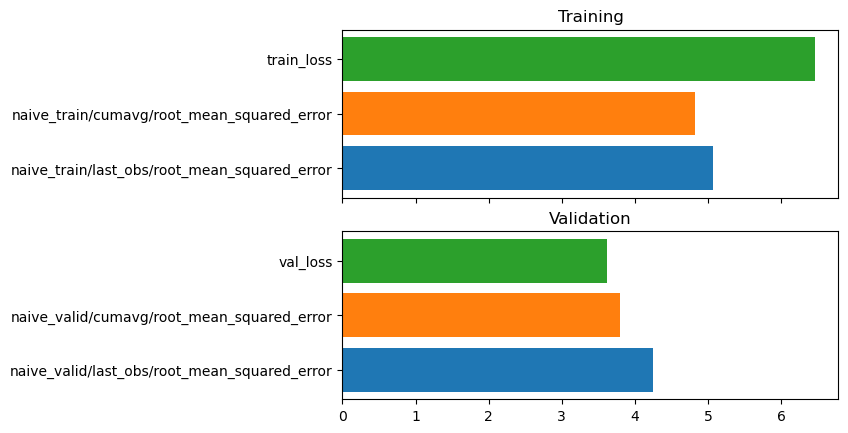

In [46]:
def plot_results(tboard_path):
    result = util.training.parse_tensorboard(tboard_path)

    train_tags = [
        "naive_train/last_obs/root_mean_squared_error",
        "naive_train/cumavg/root_mean_squared_error",
        "train_loss"
    ]
    
    valid_tags = [
        "naive_valid/last_obs/root_mean_squared_error",
        "naive_valid/cumavg/root_mean_squared_error",
        "val_loss"
    ]

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    for taglist, ax in zip([train_tags, valid_tags], [ax1, ax2]):
        for idx, tag in enumerate(taglist):
            v = result[tag].value.iloc[-1]
            if tag.endswith("loss"):
                v = np.sqrt(v)*100
    
            ax.barh(idx, v)

        ax.set_yticks([0, 1, 2], taglist)

    ax1.set_title("Training")
    ax2.set_title("Validation")

    return fig, (ax1, ax2)
        
plot_results("logs/06192025__convlstm_3layer_16hidden__4band__window_5_5_5__gfw_loss/lightning_logs/version_0/")
plt.show()

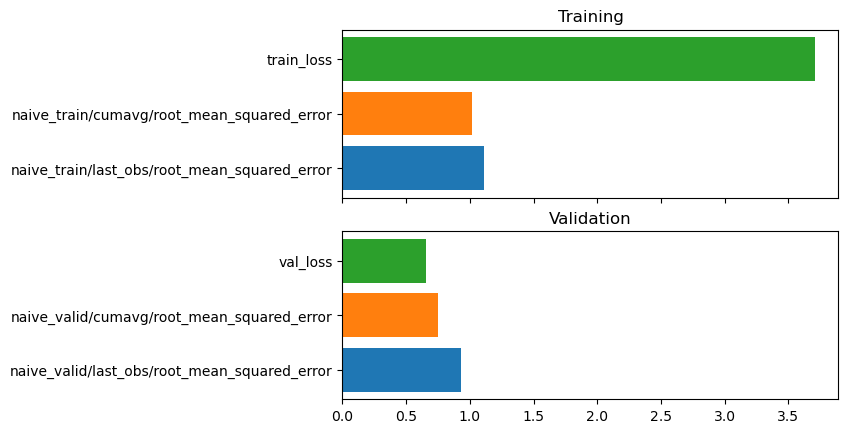

In [48]:
plot_results("logs/06192025__convlstm_3layer_16hidden__4band__window_5_5_5__gfw_masked/lightning_logs/version_0/")
plt.show()

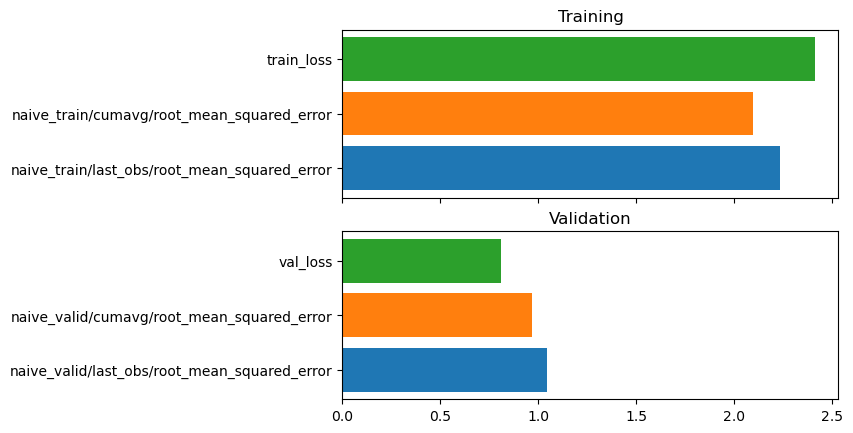

In [49]:
plot_results("logs/06192025__convlstm_3layer_16hidden__4band__window_5_5_5__mortality/lightning_logs/version_0/")
plt.show()

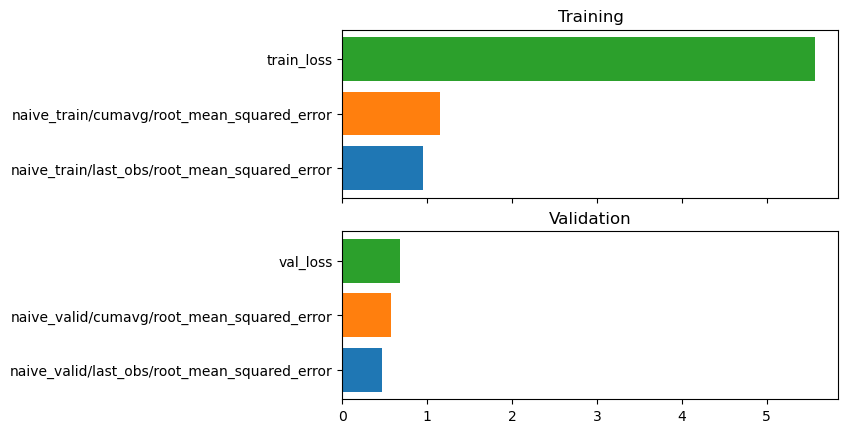

In [50]:
plot_results("logs/06192025__convlstm_3layer_16hidden__4band__window_5_5_5__mort_ewma/lightning_logs/version_0/")
plt.show()

Prediction map

In [ ]:
ds_infer = ds.sel(time=np.concatenate([valid_years, test_years]))
wds_infer = util.datasets.WindowXarrayDataset(
    ds_infer, window, 
    mask=ds_infer.sel(band="mortality"), 
    na_thresh=0.5,
    downsample_step=10
)
print(len(wds_infer))

In [ ]:
ch_means = m.convlstm.bn.running_mean.unsqueeze(-1).unsqueeze(-1)

def inference_collator(patch):
    X = torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype,
            device=device
        ).unsqueeze(0)

    # Replace nan cells with the channel mean
    X = torch.nan_to_num(X)
    X += ch_means * torch.isnan(X)
    return X

In [ ]:
out_arr = np.zeros(ds_infer.isel(band=0).shape)
out_n   = np.zeros(out_arr.shape)

m.eval()
with torch.no_grad():
    for i in tqdm(range(len(wds_infer))):
        input_tensor = inference_collator(wds_infer[i])
        t = wds_infer.valid_indices["time"][i]
        y = wds_infer.valid_indices["y"][i]
        x = wds_infer.valid_indices["x"][i]
    
        output_tensor = m(input_tensor).detach().cpu().numpy()
    
        out_arr[t, y-window_y_size+1:y+1, x-window_x_size+1:x+1] += np.log10(output_tensor[0, ...])
        out_n[t, y-window_y_size+1:y+1, x-window_x_size+1:x+1] += 1

In [ ]:
out_avg = out_arr / out_n
out_arr[out_n == 0] = np.nan
out_pct = 10 ** out_avg

out_da = xr.DataArray(
    data=out_pct,
    dims=["time", "y", "x"],
    coords=dict(
        time=ds_infer.time,
        y=ds_infer.y,
        x=ds_infer.x
    )
)

In [ ]:
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import shapely
from shapely.geometry import box

regions = gpd.read_file("data_in/regions_simple2.geojson")

fig = plt.Figure(layout="constrained", figsize=(11, 5.5))
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 1, 1])

projection = ccrs.AlbersEqualArea(central_latitude=42, central_longitude=-110)
map_ax = fig.add_subplot(gs[:, 0], projection=projection)

# Make the map
map_ax.coastlines(linewidth=0.5)

# Expand the bounding box a little so that we don't crop too much
mycrs = ccrs.epsg("3857")
bbox = box(*regions.total_bounds)
bbox = bbox.buffer(5e5) # meters

minx, miny, maxx, maxy = shapely.bounds(bbox)

# Add region geometries
for i in range(regions.shape[0]):
    geom = regions.geometry[i]
    map_ax.add_geometries(geom, crs=mycrs)
    map_ax.text(
        geom.centroid.x, geom.centroid.y, regions.name[i], 
        transform=mycrs,
        horizontalalignment="center",
        path_effects=[pe.withStroke(linewidth=4, foreground="white")]
    )

map_ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=0.5)
map_ax.set_extent((minx, maxx, miny, maxy), crs=mycrs)

axes = []

for i, (row, col) in enumerate(zip((1, 0, 1, 0), (2, 1, 1, 2))):
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)
    geom = regions.geometry[i]
    # Mean of geometric mean - no transformation necessary imo
    model = out_da.rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values * 100
    # Maybe do a geometric mean here?
    data  = ds_infer.sel(band="mort_ewma").rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values

    ax.plot(ds_infer.time, data, label="Actual", marker=".")
    ax.plot(ds_infer.time, model, label="Model", marker=".")
    ax.set_ylim(0, 2)
    ax.set_title(regions.name[i])
    ax.grid()

axes[1].legend()

fig